In [2]:
import numpy as np
import pandas as pd

In [3]:
tickers = ["BRK","MMC","PGR","ALL","AJG","MET","PRU","TRV","AIG","FNF","MKL","FAF","HIG","BRO","AIZ","AFL","UNM"]
dataframes = []

for ticker in tickers:
    dataframes.append(pd.read_csv("FinancialNumbers_"+ticker+".csv"))

for i in range(len(tickers)):
    dataframes[i]['Date'] = pd.to_datetime(dataframes[i]['Date'])
    dataframes[i].set_index('Date', inplace=True)

In [4]:
dataframes[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2014-12-31 to 2024-03-31
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Total Assets                 38 non-null     int64
 1   Retained Earnings            38 non-null     int64
 2   EBIT                         38 non-null     int64
 3   Shareholders' Equity         38 non-null     int64
 4   Cash & Equivalents           38 non-null     int64
 5   Property, Plant & Equipment  38 non-null     int64
 6   Total Debt                   38 non-null     int64
 7   Working Capital              38 non-null     int64
 8   Total Liabilities            38 non-null     int64
dtypes: int64(9)
memory usage: 3.0 KB


In [5]:
for i in range(len(dataframes)):
    print(list(dataframes[i].columns))

['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equi

In [6]:
def calcRatios(TotalAssets, RetainedEarnings, EBIT, WorkingCapital, Equity, TotalLiabilities):
    WCTA = WorkingCapital/TotalAssets
    RETA = RetainedEarnings/TotalAssets
    EBITTA = EBIT/TotalAssets
    BVETL = Equity/TotalLiabilities
    return [WCTA, RETA, EBITTA, BVETL]

In [7]:
def AltmanZScore(ratios):
    return ratios[0]*6.56 + ratios[1]*3.26 + ratios[2]*6.72 + ratios[3]*1.05

In [8]:
dataframes[0].tail()

,Total Assets,Retained Earnings,EBIT,Shareholders' Equity,Cash & Equivalents,"Property, Plant & Equipment",Total Debt,Working Capital,Total Liabilities
Date,,,,,,,,,
2023-03-31,997072,546631,45282,516260,26747,205855,123624,67410,480812
2023-06-30,1041573,582543,46173,551761,50055,209188,125347,76972,489812
2023-09-30,1019933,569776,-15961,534727,30840,211498,124781,92562,485206
2023-12-31,1069978,607350,47702,570770,38022,221870,133570,173170,499208
2024-03-31,1070035,619925,16529,577785,35549,217500,122754,119906,492250


In [14]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [15]:
#First forecast - LSTM 1 step forward for BRK
target_columns = ["Total Assets", "Retained Earnings", "EBIT", "Shareholders' Equity", "Working Capital", "Total Liabilities"]

In [16]:
# Define lag function for feature engineering
def create_lag_features(df, col, lags=3):
    df_lag = df[[col]].copy()
    for lag in range(1, lags+1):
        df_lag[f"{col}_lag{lag}"] = df_lag[col].shift(lag)
    df_lag.dropna(inplace=True)  # Remove NaNs created by shifting
    return df_lag

In [17]:
predictions = []
models_all = []

for i in range(len(dataframes)):  # Loop through each company
    # Initialize models and predictions
    models = {}
    prediction = {}

    # Get the company's dataframe
    df_company = dataframes[i]

    # Train an ARIMA model for each target column
    for col in target_columns:
        series = df_company[col].dropna()  # Remove NaN values

        # Auto-select the best (p,d,q) parameters
        auto_model = auto_arima(series, seasonal=False, stepwise=True, suppress_warnings=True)
        best_p, best_d, best_q = auto_model.order

        # Train ARIMA model
        model = ARIMA(series, order=(best_p, best_d, best_q))
        model_fit = model.fit()

        # Predict the next step
        pred = model_fit.forecast(steps=1)[0]  # Forecast one step ahead

        # Store model and prediction
        models[col] = model_fit
        prediction[col] = pred

    predictions.append(prediction)
    models_all.append(models)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\alexv\AppData\Local\Temp\ipykernel_9404\3090175168.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model_fit.forecast(steps=1)[0]  # Forecast one step ahead
C:\P

In [18]:
# Print forecasted values for 1 step ahead
for i in range(len(tickers)):
    print(f"1-Step Ahead Forecasted Values for {tickers[i]}:\n")
    for col, value in predictions[i].items():
        print(f"{col}: {value:.2f}\n")

1-Step Ahead Forecasted Values for BRK:

Total Assets: 1070035.00

Retained Earnings: 619925.00

EBIT: 13626.03

Shareholders' Equity: 577785.00

Working Capital: 115617.12

Total Liabilities: 492250.00

1-Step Ahead Forecasted Values for MMC:

Total Assets: 47714.41

Retained Earnings: 23968.75

EBIT: 1617.20

Shareholders' Equity: 12878.10

Working Capital: 1606.63

Total Liabilities: 35218.30

1-Step Ahead Forecasted Values for PGR:

Total Assets: 96440.54

Retained Earnings: 21021.00

EBIT: 2404.20

Shareholders' Equity: 22031.37

Working Capital: 8392.62

Total Liabilities: 74701.13

1-Step Ahead Forecasted Values for ALL:

Total Assets: 96440.54

Retained Earnings: 21021.00

EBIT: 2404.20

Shareholders' Equity: 22031.37

Working Capital: 18221.00

Total Liabilities: 87445.94

1-Step Ahead Forecasted Values for AJG:

Total Assets: 65040.00

Retained Earnings: 4793.78

EBIT: 720.13

Shareholders' Equity: 11599.00

Working Capital: 1704.00

Total Liabilities: 52883.56

1-Step Ahead 

In [19]:
#Calculate the ratios then get the Altman Z-score
AltmanZScores = []
for i in range(len(tickers)):
    TotalAssets = predictions[i]['Total Assets']
    RetainedEarnings = predictions[i]['Retained Earnings']
    EBIT = predictions[i]['EBIT']
    ShareholderEquity = predictions[i]["Shareholders' Equity"]
    WorkingCapital = predictions[i]['Working Capital']
    TotalLiabilities = predictions[i]['Total Liabilities']
    ratios = calcRatios(TotalAssets, RetainedEarnings, EBIT, WorkingCapital, ShareholderEquity, TotalLiabilities)
    ZScore = AltmanZScore(ratios)
    print(tickers[i]," ",ZScore)
    AltmanZScores.append(ZScore)   

BRK   3.9155139350907646
MMC   2.470219806141998
PGR   1.7586512781660792
ALL   2.382056182241224
AJG   0.7168481408759428
MET   0.8194751224493002
PRU   0.3111812195489683
TRV   1.9619387470421394
AIG   0.299493514120675
FNF   0.4800272448009618
MKL   2.485592814846172
FAF   -0.32304308556949657
HIG   0.8123314607491785
BRO   2.339095093049699
AIZ   3.942203169870058
AFL   2.231651893093729
UNM   2.236730961606044


In [20]:
#now make the confusion matrix
actuals_allcompanies = pd.read_csv("Actuals.csv")
actuals_allcompanies

,Ticker,High Risk
0,BRK,0
1,MMC,0
2,PGR,1
3,ALL,0
4,AJG,1
5,MET,1
6,PRU,1
7,TRV,0
8,AIG,1
9,FNF,1


In [21]:
high_risk = [0 if(i > 1.95) else 1 for i in AltmanZScores]
high_risk

[0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]

In [22]:
#confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
actual_labels = actuals_allcompanies['High Risk'].values
conf_matrix = confusion_matrix(actual_labels, high_risk)
print("Confusion Matrix: \n", conf_matrix)

Confusion Matrix: 
 [[9 0]
 [0 8]]


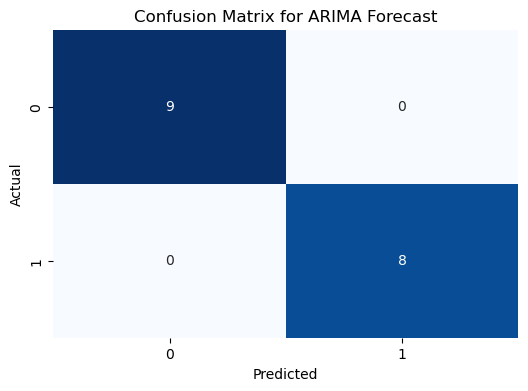

In [23]:
#graph confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for ARIMA Forecast")
plt.show()

In [24]:
# Classification Report (Precision, Recall, F1-score)
report = classification_report(actual_labels, high_risk)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17

